# Ames Data Analysis

In [2]:
from category_encoders import LeaveOneOutEncoder
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pipeline_v1 import ordinal, nominal, continuous, discrete

# Data

In [8]:
# Get Data
filename = "../data/experimental/Ames_data.csv"
ames = pd.read_csv(filename)
# Drop Outliers
ames = ames[ames["Gr_Liv_Area"]<=4000]
ames = ames[ames["Total_Bsmt_SF"]<=4000]
# Let's log transform the target before we do anthing else.
ames["Sale_Price"] = np.log(ames["Sale_Price"])
X = ames.drop(columns=["PID","Sale_Price"])
y = ames["Sale_Price"].to_numpy()
df = ames.drop(columns="PID")

# Metadata
metafile = "../data/metadata/feature_metadata.csv"
meta = pd.read_csv(metafile)
nominal = meta[(meta["Source"] == "Original") & (meta["Type"] == "Nominal")]["Feature"]
ordinal = meta[(meta["Source"] == "Original") & (meta["Type"] == "Ordinal")]["Feature"]
continuous = meta[(meta["Source"] == "Original") & (meta["Type"] == "Continuous")]["Feature"]
discrete = meta[(meta["Source"] == "Original") & (meta["Type"] == "Discrete")]["Feature"]

print(X.shape)

(2925, 81)


In [5]:
def categorical(df, var):
    fig, axes = plt.subplots(2,1, figsize=(12,8))
    sns.boxplot(x="Sale_Price", y=var, data=df, ax=axes[0])
    sns.countplot(y=var, data=df, ax=axes[1])
    fig.suptitle(var, fontsize=20)
    plt.show()

In [6]:
def numeric(df, var):
    fig, ax = plt.subplots(figsize=(12,8))
    sns.scatterplot(y="Sale_Price", x=var, data=df, ax=ax)    
    fig.suptitle(var, fontsize=20)
    plt.show()  

# Size 
Bsmt_Liv_Area = Total_Bsmt_SF - Bsmt_Unf_SF    
Total_Liv_Area = Gr_Liv_Area + Bsmt_Liv_Area

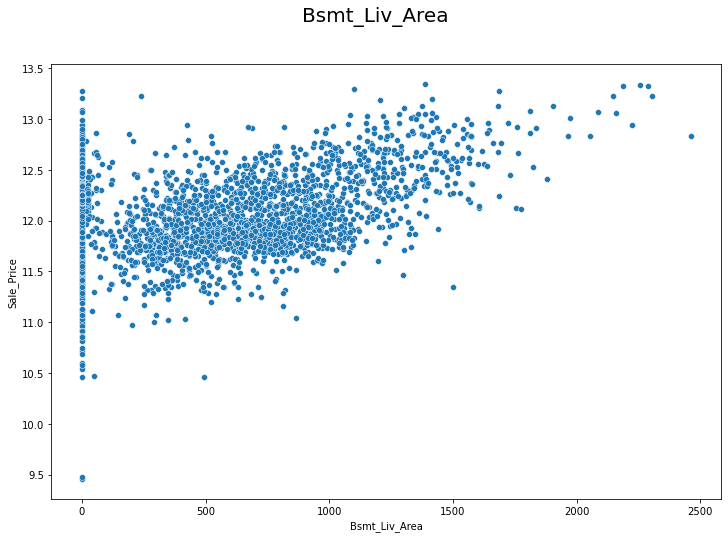

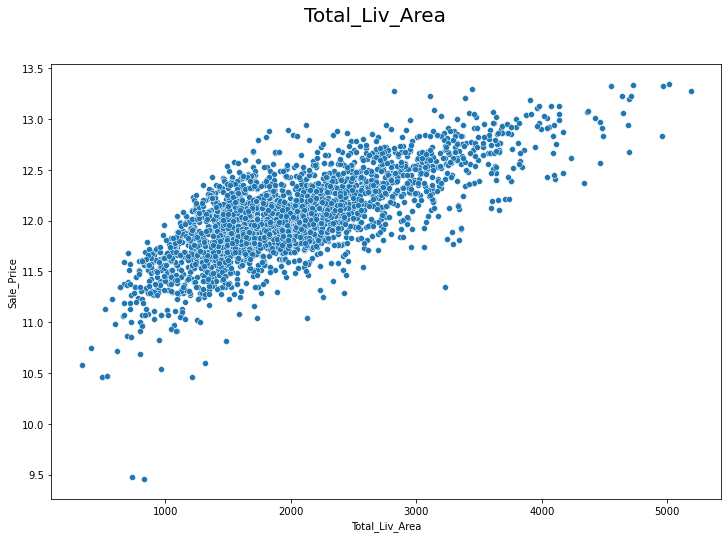

In [9]:
df["Bsmt_Liv_Area"] = df["Total_Bsmt_SF"] - df["Bsmt_Unf_SF"]
df["Total_Liv_Area"] = df["Gr_Liv_Area"] + df["Total_Bsmt_SF"] - df["Bsmt_Unf_SF"]
numeric(df, "Bsmt_Liv_Area")
numeric(df, "Total_Liv_Area")

# Location

## Neighborhood


<AxesSubplot:xlabel='Sale_Price', ylabel='Neighborhood'>

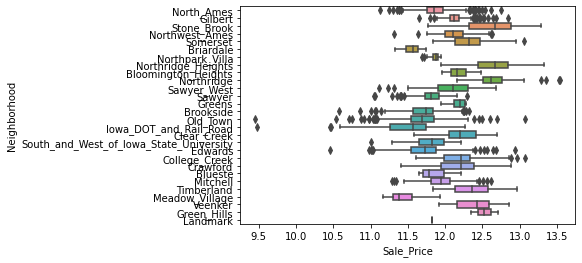

In [4]:
# Neighborhood
sns.boxplot(x="Sale_Price", y="Neighborhood", data=df)

Neighborhood alone doesn't seem to indicate very much about price. Let's look at variation and average

### Exclusivity
Variation can be an indicator of exclusivity. 

<AxesSubplot:xlabel='Exclusivity', ylabel='Sale_Price'>

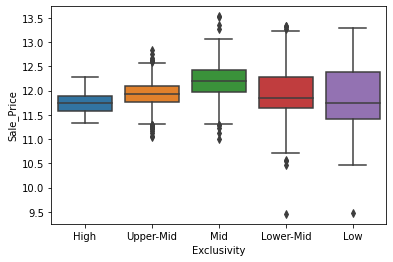

In [5]:
# Exclusivity
# Group the data by neighborhood
neighborhoods =  df.groupby(["Neighborhood"])
# Examine the variance in housing prices by neighborhood. Low variance would indicate some sort of exclusivity (hi/low)
neighborhood_stats = neighborhoods["Sale_Price"].describe()
#neighborhood_stats.sort_values(by="std")
neighborhood_stats["Exclusivity"] = pd.cut(neighborhood_stats["std"],5, labels=["High","Upper-Mid", "Mid","Lower-Mid", "Low"], include_lowest=True)
# Let's merge these new features into the dataframe
df = df.merge(neighborhood_stats["Exclusivity"], how="left", on="Neighborhood")
sns.boxplot(x="Exclusivity",y="Sale_Price", data=df)


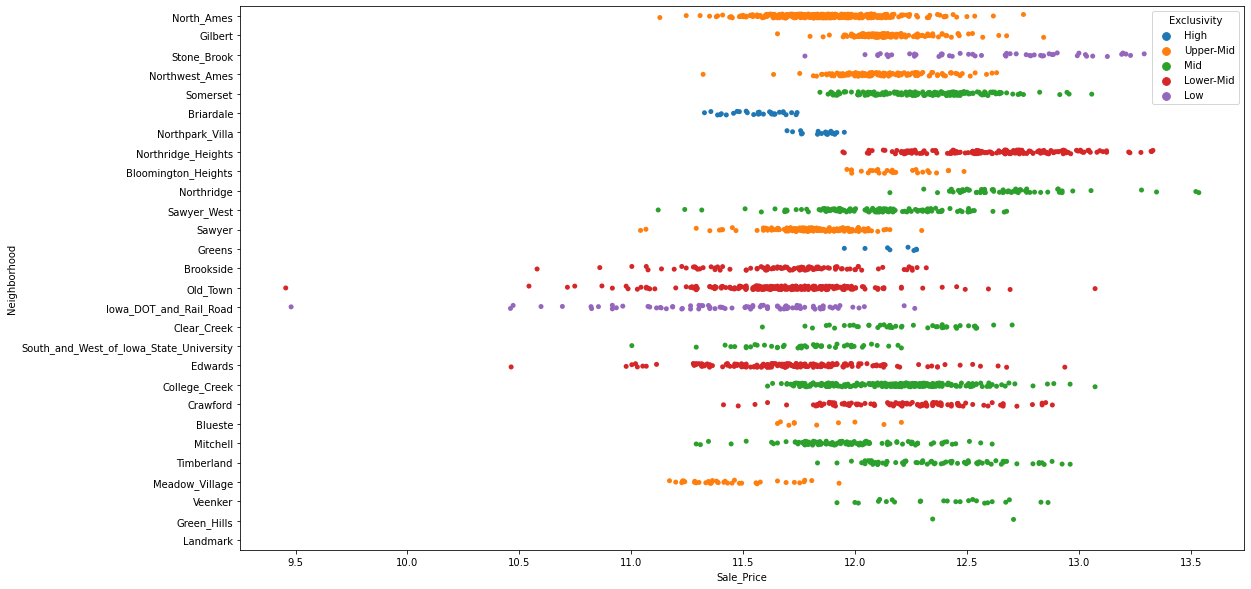

In [6]:
fig, ax = plt.subplots(figsize=(18,10))
sns.stripplot(x="Sale_Price",y="Neighborhood", hue="Exclusivity", data=df, ax=ax)
plt.show()

Some neighborhoods seem exclusively lower class. 

### Class
Let's look at average price per neighborhood in terms of class

In [7]:
# Group the data by neighborhood
neighborhoods =  df.groupby(["Neighborhood"])
# Examine the variance in housing prices by neighborhood. Low variance would indicate some sort of exclusivity (hi/low)
neighborhood_stats = neighborhoods["Sale_Price"].describe()
neighborhood_stats

,count,mean,std,min,25%,50%,75%,max
Neighborhood,,,,,,,,
Bloomington_Heights,28.0,12.178908,0.145199,11.962854,12.074956,12.162640,12.284129,12.485827
Blueste,10.0,11.856254,0.198946,11.652687,11.709467,11.777887,11.980084,12.206073
Briardale,30.0,11.560916,0.117546,11.326596,11.474694,11.571194,11.640879,11.740061
Brookside,108.0,11.690847,0.304906,10.578980,11.575166,11.749970,11.840598,12.317167
Clear_Creek,44.0,12.217974,0.252970,11.585246,12.049210,12.193414,12.407175,12.700769
College_Creek,267.0,12.181596,0.257352,11.608236,11.988368,12.206073,12.338196,13.071070
Crawford,103.0,12.195976,0.308662,11.411446,11.950858,12.209188,12.382122,12.880292
Edwards,194.0,11.726375,0.327355,10.463103,11.547568,11.736069,11.883625,12.936034
Gilbert,165.0,12.145524,0.154138,11.652687,12.061047,12.117241,12.183316,12.841326


In [8]:
# Let's bin average price into 5 categories, High, Upper-Middle, Middle, Working Class and Lower
neighborhood_stats["Class"] = pd.cut(neighborhood_stats["mean"],5, labels=["Low","Lower-Mid", "Mid","Upper-Mid", "High"], include_lowest=True)
neighborhood_stats


,count,mean,std,min,25%,50%,75%,max,Class
Neighborhood,,,,,,,,,
Bloomington_Heights,28.0,12.178908,0.145199,11.962854,12.074956,12.162640,12.284129,12.485827,Mid
Blueste,10.0,11.856254,0.198946,11.652687,11.709467,11.777887,11.980084,12.206073,Lower-Mid
Briardale,30.0,11.560916,0.117546,11.326596,11.474694,11.571194,11.640879,11.740061,Low
Brookside,108.0,11.690847,0.304906,10.578980,11.575166,11.749970,11.840598,12.317167,Low
Clear_Creek,44.0,12.217974,0.252970,11.585246,12.049210,12.193414,12.407175,12.700769,Upper-Mid
College_Creek,267.0,12.181596,0.257352,11.608236,11.988368,12.206073,12.338196,13.071070,Mid
Crawford,103.0,12.195976,0.308662,11.411446,11.950858,12.209188,12.382122,12.880292,Upper-Mid
Edwards,194.0,11.726375,0.327355,10.463103,11.547568,11.736069,11.883625,12.936034,Lower-Mid
Gilbert,165.0,12.145524,0.154138,11.652687,12.061047,12.117241,12.183316,12.841326,Mid


<AxesSubplot:xlabel='Class', ylabel='Sale_Price'>

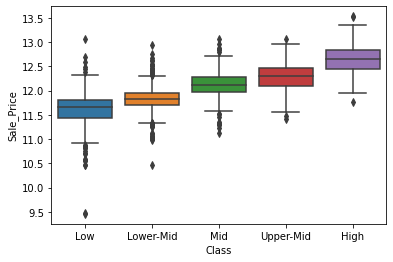

In [9]:
# Let's merge these new features into the dataframe
df = df.merge(neighborhood_stats["Class"], how="left", on="Neighborhood")
# Lets plot Sale price against class.
sns.boxplot(x="Class",y="Sale_Price", data=df)

Now lets look at class and exclusivity together.


<AxesSubplot:xlabel='Sale_Price', ylabel='Class'>

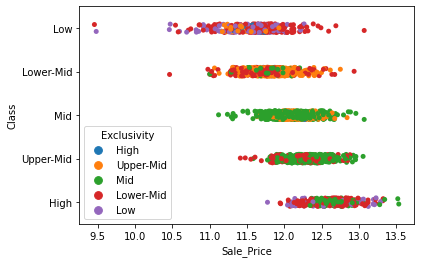

In [10]:
sns.stripplot(x="Sale_Price",y="Class", hue="Exclusivity", data=df)

Let's run a simple regression and see if the variables are independently or collectively significant

In [11]:
df = pd.concat((df, pd.get_dummies(df[["Class","Exclusivity"]], prefix=["class","xclsv"],drop_first=True)), axis=1)
y = df["Sale_Price"]
X = df[["class_Lower-Mid", "class_Mid", "class_Upper-Mid", "class_High"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale_Price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     912.9
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:24:20   Log-Likelihood:                -340.35
No. Observations:                2930   AIC:                             690.7
Df Residuals:                    2925   BIC:                             720.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6172      0.012    961.666      0.000      11.594      11.641
x1             0.2019      0.015     13.286      0.000       0.172       0.232
x2             0.5051      0.015     33.001      0.000       0.475       0.535
x3             0.6740      0.018     37.678      0.000       0.639       0.709
x4             1.0264      0.020     51.252      0.000       0.987       1.066
==============================================================================
Omnibus:                      365.263   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2052.689
Skew:                          -0.451   Prob(JB):                         0.00
Kurtosis:                       7.000   Cond. No.                         6.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ok. One variable accounts for over half the variation in Sale Price. Let's see what Exclusivity does.

In [12]:
y = df["Sale_Price"]
X = df[["xclsv_Lower-Mid", "xclsv_Mid", "xclsv_Upper-Mid", "xclsv_Low"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale_Price   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     87.46
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           2.77e-70
Time:                        17:24:20   Log-Likelihood:                -1361.8
No. Observations:                2930   AIC:                             2734.
Df Residuals:                    2925   BIC:                             2764.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7515      0.049    240.052      0.000      11.656      11.848
x1             0.2010      0.051      3.957      0.000       0.101       0.301
x2             0.4567      0.051      9.039      0.000       0.358       0.556
x3             0.1810      0.051      3.584      0.000       0.082       0.280
x4             0.1290      0.059      2.203      0.028       0.014       0.244
==============================================================================
Omnibus:                      157.682   Durbin-Watson:                   0.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              541.725
Skew:                           0.161   Prob(JB):                    2.32e-118
Kurtosis:                       5.082   Cond. No.                         17.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Exclusivity alone does nothing really.

In [13]:
y = df["Sale_Price"]
X = df[[ "class_Lower-Mid", "class_Mid", "class_Upper-Mid", "class_High","xclsv_Lower-Mid", "xclsv_Mid", "xclsv_Upper-Mid", "xclsv_Low"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale_Price   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     467.8
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:24:20   Log-Likelihood:                -319.18
No. Observations:                2930   AIC:                             656.4
Df Residuals:                    2921   BIC:                             710.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6431      0.036    327.220      0.000      11.573      11.713
x1             0.1354      0.019      7.190      0.000       0.099       0.172
x2             0.4337      0.021     20.854      0.000       0.393       0.474
x3             0.6224      0.022     28.474      0.000       0.580       0.665
x4             1.0191      0.020     50.169      0.000       0.979       1.059
x5            -0.0111      0.036     -0.308      0.758      -0.081       0.059
x6             0.0374      0.037      1.003      0.316      -0.036       0.111
x7             0.0590      0.036      1.623      0.105      -0.012       0.130
x8            -0.1236      0.042     -2.942      0.003      -0.206      -0.041
==============================================================================
Omnibus:                      315.635   Durbin-Watson:                   1.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1797.715
Skew:                          -0.343   Prob(JB):                         0.00
Kurtosis:                       6.775   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only slightly better than Class alone. Ok, let's examine the quality dimension of locality in terms of:
- Overall quality
- Overall Condition
- External quality
- External Condition
- Functionality
First, let's encode each variable with using leave-one-out target mean encoding.

In [14]:
# 
enc = LeaveOneOutEncoder(sigma=0.3)
df["Overall_Qual_LOOE"] = enc.fit_transform(X=df["Overall_Qual"], y=df["Sale_Price"])
df["Overall_Cond_LOOE"] = enc.fit_transform(X=df["Overall_Cond"], y=df["Sale_Price"])
df["Exter_Qual_LOOE"] = enc.fit_transform(X=df["Exter_Qual"], y=df["Sale_Price"])
df["Exter_Cond_LOOE"] = enc.fit_transform(X=df["Exter_Cond"], y=df["Sale_Price"])

In [15]:
#Look at Overall Quality by Neighborhood
# Quality is normalized sum of the overall and external quality and functionality features
df["Quality"] = (\
    df["Overall_Qual_LOOE"]/df["Overall_Qual_LOOE"].mean() + 
    df["Overall_Cond_LOOE"]/df["Overall_Cond_LOOE"].mean() + 
    df["Exter_Qual_LOOE"]/df["Exter_Qual_LOOE"].mean() + 
    df["Exter_Cond_LOOE"]/df["Exter_Cond_LOOE"].mean()) 

# Let's summarize quality by neighborhood
hoods = df.groupby(by="Neighborhood")
hoods_summary = hoods["Quality"].describe().sort_values(by="mean")



Ok,lets split the neighborhoods into 5 categories w.r.t quality.


In [16]:
hoods_summary["Neighborhood_Quality"] = pd.qcut(hoods_summary["mean"],5, labels=["Poor","Fair", "Average","Good", "Excellent"])
hoods_summary

,count,mean,std,min,25%,50%,75%,max,Neighborhood_Quality
Neighborhood,,,,,,,,,
Landmark,1.0,3.232535,NaN,3.232535,3.232535,3.232535,3.232535,3.232535,Poor
Blueste,10.0,3.736880,0.488614,3.070715,3.369357,3.628307,4.211489,4.374795,Poor
Briardale,30.0,3.801120,0.545073,2.647089,3.464043,3.936172,4.087185,5.220850,Poor
Veenker,24.0,3.822172,0.459031,2.947692,3.506355,3.897138,4.168436,4.560936,Poor
South_and_West_of_Iowa_State_University,48.0,3.854565,0.583360,2.168517,3.521204,3.895828,4.200670,4.722887,Poor
Bloomington_Heights,28.0,3.879898,0.515558,2.405958,3.501406,4.040593,4.304480,4.579718,Poor
Clear_Creek,44.0,3.907692,0.573949,2.715052,3.488742,3.944300,4.250371,4.968610,Fair
Sawyer,151.0,3.911101,0.627708,2.416831,3.521609,3.969065,4.307575,5.175926,Fair
Iowa_DOT_and_Rail_Road,93.0,3.911895,0.571588,2.138318,3.561731,3.848283,4.323655,5.116237,Fair


Kind of concerned with the distribution assigning poor and excellent only to the far extremes. Let's the docs indicate that the bins are of equal size and so this suggests a Gaussian distribution. Let's plot something, but first we need to merge this data with the main dataset. Then we'll see how neighborhood and quality effects price.

In [17]:
df = df.merge(hoods_summary["Neighborhood_Quality"], how="left", on="Neighborhood")
df.head()


,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,First_Flr_SF,Second_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude,Sale_Price,Exclusivity,Class,class_Lower-Mid,class_Mid,class_Upper-Mid,class_High,xclsv_Upper-Mid,xclsv_Mid,xclsv_Lower-Mid,xclsv_Low,Overall_Qual_LOOE,Overall_Cond_LOOE,Exter_Qual_LOOE,Exter_Cond_LOOE,Quality,Neighborhood_Quality
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Above_Average,Average,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112,Typical,Typical,CBlock,Typical,Good,Gd,BLQ,2,Unf,0,441,1080,GasA,Fair,Y,SBrkr,1656,0,0,1656,1,0,1,0,3,1,Typical,7,Typ,2,Good,Attchd,1960.0,Fin,2,528,Typical,Typical,Partial_Pavement,210,62,0,0,0,0,No_Pool,No_Fence,None,0,5,2010,WD,Normal,-93.619754,42.054035,12.278393,Upper-Mid,Lower-Mid,1,0,0,0,1,0,0,0,8.758116,16.602790,15.695241,12.466453,4.446961,Average
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,North_Ames,Feedr,Norm,OneFam,One_Story,Average,Above_Average,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,Typical,Typical,CBlock,Typical,Typical,No,Rec,6,LwQ,144,270,882,GasA,Typical,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,Typical,5,Typ,0,No_Fireplace,Attchd,1961.0,Unf,1,730,Typical,Typical,Paved,140,0,0,0,120,0,No_Pool,Minimum_Privacy,None,0,6,2010,WD,Normal,-93.619756,42.053014,11.561716,Upper-Mid,Lower-Mid,1,0,0,0,1,0,0,0,11.346444,12.457379,16.527740,11.385592,4.293363,Average
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Above_Average,Above_Average,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108,Typical,Typical,CBlock,Typical,Typical,No,ALQ,1,Unf,0,406,1329,GasA,Typical,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,Good,6,Typ,0,No_Fireplace,Attchd,1958.0,Unf,1,312,Typical,Typical,Paved,393,36,0,0,0,0,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,-93.619387,42.052659,12.055250,Upper-Mid,Lower-Mid,1,0,0,0,1,0,0,0,12.689617,9.840777,12.059513,20.871370,4.606684,Average
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Good,Average,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0,Good,Typical,CBlock,Typical,Typical,No,ALQ,1,Unf,0,1045,2110,GasA,Excellent,Y,SBrkr,2110,0,0,2110,1,0,2,1,3,1,Excellent,8,Typ,2,Typical,Attchd,1968.0,Fin,2,522,Typical,Typical,Paved,0,0,0,0,0,0,No_Pool,No_Fence,None,0,4,2010,WD,Normal,-93.617320,42.051245,12.404924,Upper-Mid,Lower-Mid,1,0,0,0,1,0,0,0,7.969775,19.213483,8.723156,7.673431,3.620840,Average
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,OneFam,Two_Story,Average,Average,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0,Typical,Typical,PConc,Good,Typical,No,GLQ,3,Unf,0,137,928,GasA,Good,Y,SBrkr,928,701,0,1629,0,0,2,1,3,1,Typical,6,Typ,1,Typical,Attchd,1997.0,Fin,2,482,Typical,Typical,Paved,212,34,0,0,0,0,No

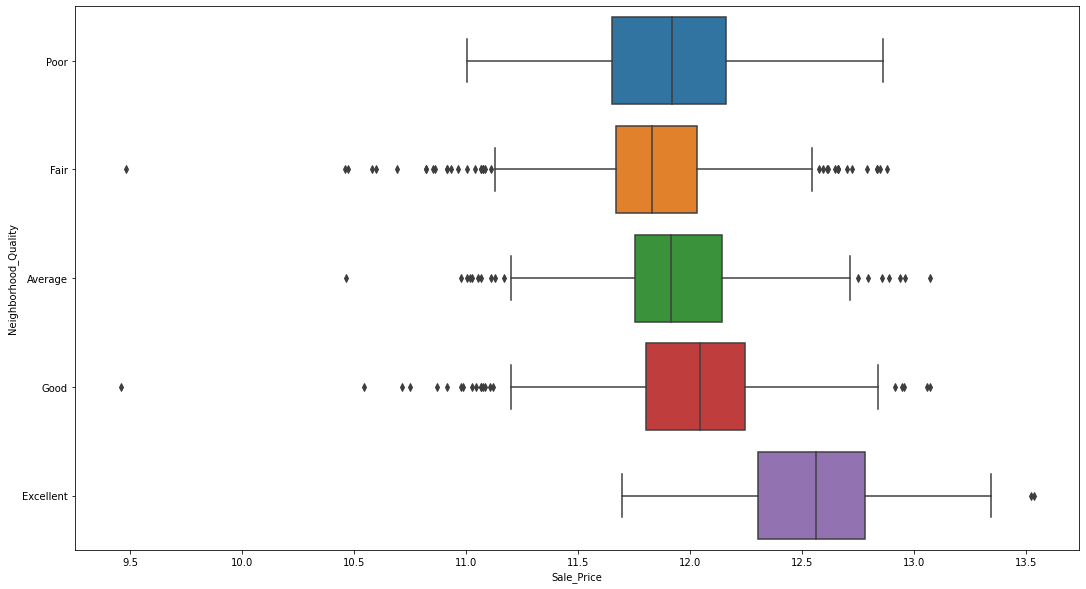

In [18]:
fig, ax = plt.subplots(figsize=(18,10))
#sort_order = df.Sale_Price.sort_values().index 
#df_sorted = df[sort_order]
sns.boxplot(x="Sale_Price",y="Neighborhood_Quality", data=df)
plt.show()

Let's try an anova to see if there are significant differences in the means at the various levels. But first, we need to encode Neighborhood Quality as a numeric. Since these are ordinal, lets use target encoding, specifically leave one out.   

In [19]:

df.loc[df["Neighborhood_Quality"]=="Poor", 'Neighborhood_Quality_ENC'] = 1
df.loc[df["Neighborhood_Quality"]=="Fair",'Neighborhood_Quality_ENC'] = 2
df.loc[df["Neighborhood_Quality"]=="Average",'Neighborhood_Quality_ENC'] = 3
df.loc[df["Neighborhood_Quality"]=="Good",'Neighborhood_Quality_ENC'] = 4
df.loc[df["Neighborhood_Quality"]=="Excellent",'Neighborhood_Quality_ENC'] = 5


In [20]:
f_oneway(df["Sale_Price"][df["Neighborhood_Quality_ENC"]==1],
               df["Sale_Price"][df["Neighborhood_Quality_ENC"]==2],
               df["Sale_Price"][df["Neighborhood_Quality_ENC"]==3],
               df["Sale_Price"][df["Neighborhood_Quality_ENC"]==4],
               df["Sale_Price"][df["Neighborhood_Quality_ENC"]==5])

F_onewayResult(statistic=272.58594971079646, pvalue=2.3153294967503598e-199)

Let's check how much variation is explained by neighborhood quality.

In [21]:
y = df["Sale_Price"]
X = df[["Neighborhood_Quality_ENC"]].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale_Price   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     605.4
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          1.16e-121
Time:                        17:24:22   Log-Likelihood:                -1252.0
No. Observations:                2930   AIC:                             2508.
Df Residuals:                    2928   BIC:                             2520.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4921      0.023    509.324      0.000      11.448      11.536
x1             0.1614      0.007     24.604      0.000       0.148       0.174
==============================================================================
Omnibus:                      174.663   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.611
Skew:                          -0.286   Prob(JB):                    1.33e-111
Kurtosis:                       4.963   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Still 25% variation explained for one variable isn't that bad. 

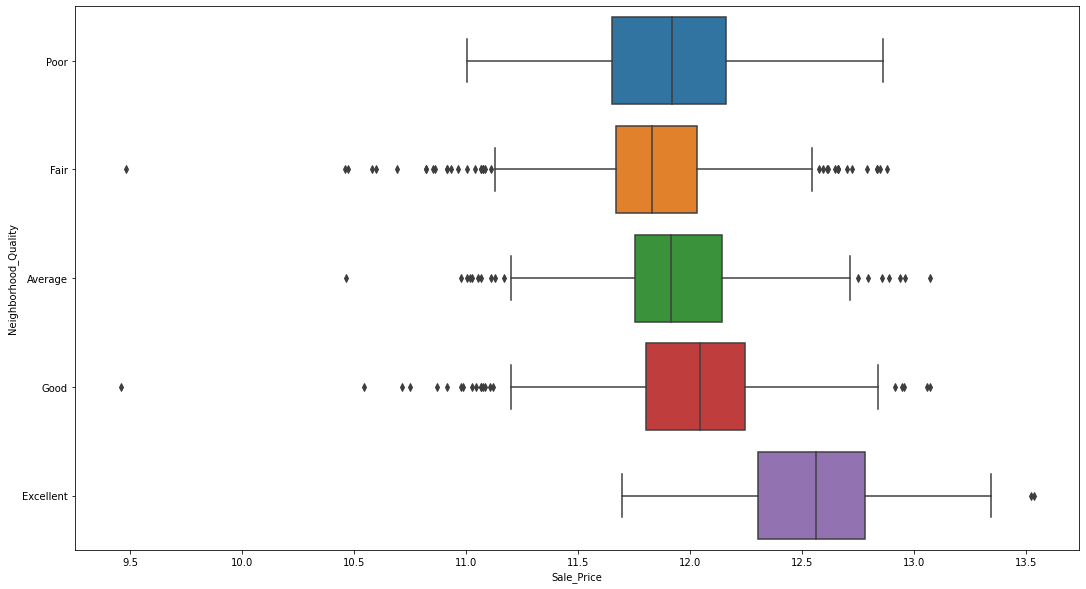

In [22]:
fig, ax = plt.subplots(figsize=(18,10))
sns.boxplot(x="Sale_Price",y="Neighborhood_Quality", data=df)
plt.show()

In [23]:
# Garage
print(f"BsmtFin_Type_1:\n{{{df['BsmtFin_Type_1'].value_counts()}}}\n")
print(f"BsmtFin_Type_2:\n{{{df['BsmtFin_Type_2'].value_counts()}}}\n")
print(f"Pool_QC:\n{{{df['Pool_QC'].value_counts()}}}\n")


BsmtFin_Type_1:
{GLQ            859
Unf            851
ALQ            429
Rec            288
BLQ            269
LwQ            154
No_Basement     80
Name: BsmtFin_Type_1, dtype: int64}

BsmtFin_Type_2:
{Unf            2499
Rec             106
LwQ              89
No_Basement      81
BLQ              68
ALQ              53
GLQ              34
Name: BsmtFin_Type_2, dtype: int64}

Pool_QC:
{No_Pool      2917
Good            4
Excellent       4
Typical         3
Fair            2
Name: Pool_QC, dtype: int64}



In [24]:
# Quality
df["Quality"] = ((df["Overall_Qual"]/df["Overall_Qual"].mean()) +
                (df["Overall_Cond"]/df["Overall_Cond"].mean()) + 
                (df["Exter_Qual"]/df["Exter_Qual"].mean()) + 
                (df["Exter_Cond"]/df["Exter_Cond"].mean()) + 
                (df["Bsmt_Qual"]/df["Bsmt_Qual"].mean()) + 
                (df["Bsmt_Cond"]/df["Bsmt_Cond"].mean()) + 
                (df["Kitchen_Qual"]/df["Kitchen_Qual"].mean()) + 
                (df["Bsmt_Cond"]/df["Bsmt_Cond"].mean()) +
                (df["Functional"]/df["Functional"].mean()))
neighborhood = df.groupby(['Neighborhood'])                
quality = neighborhood["Quality"].mean()
quality

TypeError: Could not convert Above_AverageAverageAbove_AverageGoodAverageAbove_AverageVery_GoodVery_GoodVery_GoodGoodAbove_AverageAbove_AverageAbove_AverageGoodVery_GoodVery_GoodVery_GoodExcellentBelow_AverageAbove_AverageAbove_AverageGoodGoodAbove_AverageAverageAverageBelow_AverageBelow_AverageGoodAbove_AverageAverageAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageExcellentVery_GoodExcellentVery_GoodGoodExcellentVery_GoodGoodExcellentGoodExcellentVery_GoodExcellentVery_GoodGoodAbove_AverageGoodVery_GoodGoodAbove_AverageGoodGoodGoodExcellentVery_GoodGoodVery_GoodVery_GoodGoodVery_GoodVery_GoodGoodGoodVery_GoodGoodAbove_AverageGoodGoodGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageAbove_AverageAverageAbove_AverageAverageAverageAverageAverageAverageAbove_AverageGoodVery_GoodVery_GoodGoodGoodGoodGoodGoodAbove_AverageGoodAbove_AverageAbove_AverageGoodGoodVery_GoodVery_GoodVery_GoodVery_GoodAbove_AverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageAbove_AverageAverageAbove_AverageBelow_AverageAverageAverageAbove_AverageAverageAbove_AverageAverageAverageAverageAbove_AverageAverageFairAverageAbove_AverageAverageAbove_AverageAverageGoodAbove_AverageAverageGoodAverageAverageAverageAbove_AverageAverageAverageAverageAbove_AverageBelow_AverageAverageAverageAverageAverageBelow_AverageAverageAverageAverageAbove_AverageAbove_AverageAverageGoodAbove_AverageAverageAverageAverageAbove_AverageAverageAbove_AverageAbove_AverageBelow_AverageBelow_AverageAverageAverageAverageFairBelow_AverageAverageAverageAbove_AverageAverageAveragePoorAbove_AverageVery_GoodAverageVery_GoodAverageAbove_AverageBelow_AverageBelow_AverageAbove_AverageAverageGoodBelow_AverageAbove_AverageAbove_AverageAverageAbove_AverageAverageAverageAbove_AverageGoodBelow_AverageAbove_AverageAbove_AverageAverageBelow_AverageAverageGoodAverageAverageAverageAbove_AverageBelow_AverageAverageAverageBelow_AverageBelow_AverageAverageAverageAverageAverageAverageAbove_AverageAverageAverageAverageAbove_AverageGoodGoodBelow_AverageBelow_AverageGoodAbove_AverageFairAverageAbove_AverageAverageBelow_AverageAverageAbove_AverageGoodAverageBelow_AverageAbove_AverageGoodAbove_AverageGoodAbove_AverageVery_GoodGoodGoodGoodGoodAbove_AverageAbove_AverageAverageGoodAbove_AverageAverageAbove_AverageAverageAverageVery_GoodVery_GoodGoodGoodGoodAbove_AverageAbove_AverageVery_GoodGoodGoodFairAverageAverageAverageBelow_AverageAbove_AverageAbove_AverageBelow_AverageBelow_AverageAbove_AverageBelow_AverageAverageAverageAbove_AverageFairAverageAbove_AverageBelow_AverageAverageAbove_AverageGoodAverageGoodGoodGoodVery_GoodVery_GoodGoodBelow_AveragePoorAbove_AverageBelow_AverageBelow_AverageAverageBelow_AverageVery_GoodVery_GoodAbove_AverageGoodAbove_AverageAbove_AverageAverageGoodGoodAverageVery_GoodGoodVery_GoodExcellentAverageAverageAbove_AverageAverageBelow_AverageAverageAverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageAverageAverageAverageAverageAverageAverageVery_GoodAbove_AverageAbove_AverageAbove_AverageVery_GoodAbove_AverageVery_GoodGoodExcellentGoodVery_GoodVery_GoodVery_GoodVery_GoodGoodGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodGoodVery_GoodExcellentVery_GoodGoodAverageGoodAbove_AverageGoodAbove_AverageGoodAbove_AverageGoodGoodAbove_AverageVery_GoodGoodGoodAverageGoodVery_GoodVery_GoodVery_GoodAverageAbove_AverageGoodAbove_AverageAbove_AverageAverageAverageAbove_AverageAverageAverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageAbove_AverageAverageAverageAbove_AverageAbove_AverageAverageAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodAverageAverageVery_ExcellentExcellentExcellentVery_ExcellentExcellentVery_GoodVery_GoodExcellentExcellentExcellentVery_ExcellentVery_ExcellentVery_ExcellentExcellentExcellentVery_GoodVery_GoodVery_GoodExcellentVery_GoodExcellentExcellentExcellentVery_GoodVery_GoodGoodGoodVery_ExcellentExcellentVery_GoodVery_GoodAbove_AverageAbove_AverageAbove_AverageGoodGoodVery_ExcellentVery_GoodExcellentExcellentVery_GoodVery_GoodGoodGoodGoodAbove_AverageAbove_AverageAbove_AverageGoodGoodGoodGoodGoodGoodGoodAbove_AverageGoodGoodVery_GoodGoodGoodGoodGoodGoodVery_GoodAbove_AverageGoodAbove_AverageAbove_AverageGoodGoodAbove_AverageGoodGoodVery_GoodVery_GoodVery_GoodVery_GoodVery_GoodGoodVery_GoodGoodGoodVery_GoodVery_GoodGoodVery_GoodVery_GoodVery_GoodVery_GoodVery_GoodVery_GoodGoodExcellentGoodVery_GoodAbove_AverageGoodVery_GoodGoodExcellentExcellentVery_GoodVery_ExcellentVery_GoodVery_GoodGoodVery_GoodGoodGoodGoodGoodGoodGoodGoodAbove_AverageGoodVery_GoodGoodGoodAverageAverageGoodGoodVery_GoodGoodAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageAbove_AverageBelow_AverageAbove_AverageAverageAverageAverageAverageAverageAverageAverageAverageAverageVery_GoodGoodGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodVery_GoodVery_GoodVery_GoodGoodVery_GoodBelow_AverageAbove_AverageAbove_AverageAbove_AverageGoodGoodAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageGoodAbove_AverageGoodVery_GoodAverageAverageAverageGoodAbove_AverageAbove_AverageBelow_AverageAverageAbove_AverageBelow_AverageAverageAverageAbove_AverageAverageAverageAverageAverageAbove_AverageAverageAbove_AverageAverageBelow_AverageAverageAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageAverageAverageAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageAbove_AverageBelow_AverageAverageAbove_AverageGoodAbove_AverageAbove_AverageAbove_AverageAverageAverageBelow_AverageAbove_AverageAverageAverageAbove_AverageAverageAverageBelow_AverageAverageAverageAverageAverageFairGoodAverageAbove_AverageFairAverageAverageBelow_AverageAverageAverageBelow_AverageGoodPoorBelow_AverageAverageFairAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageAbove_AverageAverageAbove_AverageAbove_AverageAverageFairAbove_AverageBelow_AverageAverageAverageAverageAverageAverageAverageBelow_AverageAbove_AverageAbove_AverageAverageAbove_AverageAverageAbove_AverageAverageAbove_AverageAbove_AverageAverageAverageAverageAverageAverageBelow_AverageAverageGoodAverageBelow_AverageAverageAverageBelow_AveragePoorFairAverageAverageBelow_AverageBelow_AverageAverageAverageGoodAbove_AverageAbove_AverageVery_GoodBelow_AverageGoodAverageAverageAbove_AverageAbove_AverageBelow_AverageFairAverageAbove_AverageGoodAverageAbove_AverageBelow_AverageAbove_AverageAverageAbove_AverageAverageAbove_AverageAverageAverageBelow_AveragePoorAverageAverageAverageAverageAbove_AverageGoodAbove_AverageGoodGoodAbove_AverageAverageAbove_AverageBelow_AverageAbove_AverageGoodAbove_AverageBelow_AverageAbove_AverageBelow_AverageAverageAverageAverageVery_PoorAbove_AverageAverageAverageAverageAbove_AverageAverageAverageAbove_AverageAverageAverageAverageAverageAbove_AverageAveragePoorBelow_AverageAverageBelow_AverageBelow_AverageAverageFairBelow_AverageAbove_AverageAverageAverageAbove_AverageBelow_AverageAverageBelow_AverageAverageAverageAbove_AverageBelow_AverageGoodAbove_AverageVery_GoodGoodGoodGoodVery_GoodAverageAverageAverageAverageAverageAverageAverageAverageAverageGoodGoodGoodExcellentVery_GoodVery_GoodExcellentVery_GoodVery_GoodVery_GoodExcellentGoodGoodVery_GoodGoodVery_GoodAbove_AverageGoodGoodAverageAverageAverageAbove_AverageGoodGoodAverageAverageGoodGoodGoodAbove_AverageGoodGoodGoodGoodGoodGoodAverageAverageAverageAverageAverageAverageAverageAverageAverageAverageGoodVery_GoodVery_GoodVery_GoodExcellentGoodGoodVery_GoodGoodVery_GoodGoodGoodGoodGoodGoodAbove_AverageAbove_AverageVery_GoodGoodGoodAbove_AverageAbove_AverageBelow_AverageAverageBelow_AverageGoodAbove_AverageBelow_AverageAbove_AverageExcellentAbove_AverageAverageBelow_AverageAverageBelow_AverageAverageFairAverageAverageBelow_AverageAbove_AverageAverageAverageAverageAveragePoorAbove_AverageGoodAbove_AverageBelow_AverageAbove_AverageAbove_AverageGoodAbove_AverageGoodGoodGoodAverageAbove_AverageAverageAverageAverageAverageGoodAverageGoodAbove_AverageAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageAverageAverageAverageFairBelow_AverageVery_GoodPoorVery_GoodGoodGoodAbove_AverageAbove_AverageAbove_AverageAverageGoodAverageAbove_AverageGoodExcellentGoodExcellentExcellentVery_GoodAbove_AverageAbove_AverageGoodVery_GoodGoodExcellentExcellentAverageAverageAbove_AverageAbove_AverageBelow_AverageAverageBelow_AverageAverageBelow_AverageBelow_AverageBelow_AverageAverageAbove_AverageAverageAverageAverageAverageAverageAbove_AverageAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageGoodVery_GoodVery_GoodVery_GoodVery_GoodAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageVery_GoodVery_GoodVery_GoodExcellentExcellentAbove_AverageExcellentAbove_AverageGoodGoodAbove_AverageGoodGoodGoodAbove_AverageAbove_AverageAverageGoodAverageGoodAbove_AverageAbove_AverageGoodAverageVery_GoodAverageAbove_AverageBelow_AverageAverageBelow_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageAbove_AverageGoodAverageVery_GoodVery_ExcellentVery_ExcellentExcellentVery_GoodVery_GoodVery_GoodExcellentExcellentVery_ExcellentExcellentVery_GoodVery_GoodVery_ExcellentExcellentGoodVery_GoodVery_GoodVery_GoodExcellentExcellentGoodVery_GoodExcellentExcellentVery_GoodVery_GoodGoodGoodGoodGoodGoodGoodGoodGoodAbove_AverageAbove_AverageGoodAbove_AverageGoodGoodGoodAbove_AverageGoodGoodGoodGoodGoodVery_GoodVery_GoodVery_GoodExcellentVery_GoodGoodVery_GoodVery_GoodGoodGoodGoodVery_GoodVery_GoodAbove_AverageVery_GoodGoodExcellentVery_GoodGoodVery_GoodVery_GoodVery_GoodVery_GoodGoodGoodGoodVery_GoodGoodVery_GoodGoodVery_GoodGoodAbove_AverageGoodAbove_AverageGoodAbove_AverageAverageAbove_AverageAbove_AverageGoodAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAverageAverageAverageAverageAbove_AverageAbove_AverageAverageAbove_AverageExcellentGoodGoodGoodAbove_AverageGoodGoodGoodAbove_AverageExcellentExcellentExcellentExcellentExcellentGoodGoodGoodVery_GoodVery_GoodVery_ExcellentVery_GoodVery_GoodVery_GoodAbove_AverageExcellentVery_GoodGoodGoodAbove_AverageAbove_AverageAbove_AverageGoodAverageAbove_AverageAverageAverageAverageAverageAverageAverageGoodVery_GoodAbove_AverageAbove_AverageGoodGoodAverageBelow_AverageBelow_AverageAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageAverageAverageAbove_AverageBelow_AverageAverageFairFairAverageBelow_AverageAverageAbove_AverageAverageAbove_AverageAverageGoodAbove_AverageAverageAbove_AverageAbove_AverageAbove_AverageAverageAverageAverageAverageAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAverageAverageAverageAbove_AverageAverageAverageAverageAverageAverageBelow_AverageAverageAverageBelow_AverageAverageBelow_AverageAbove_AverageAverageGoodAbove_AverageAbove_AverageGoodAverageAverageAverageAverageAverageAverageAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAverageAverageAbove_AverageAbove_AverageAverageAbove_AverageAverageAverageAverageAverageAbove_AverageAverageAbove_AverageBelow_AverageGoodBelow_AverageAverageGoodAbove_AverageAverageAverageAverageAverageAveragePoorAverageBelow_AverageFairGoodAverageAverageGoodAverageAverageAverageAbove_AverageAverageGoodAbove_AverageAbove_AverageVery_GoodGoodVery_ExcellentPoorGoodAverageAverageAverageBelow_AverageAverageGoodAverageAverageAverageAverageAbove_AverageAbove_AverageAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageBelow_AverageBelow_AverageAverageAverageGoodAverageGoodAbove_AverageBelow_AverageAverageAbove_AverageGoodAbove_AverageAverageAbove_AverageAbove_AverageVery_GoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageAverageFairAbove_AverageAverageAverageAverageBelow_AverageAverageAverageAverageAbove_AverageAverageAverageAverageAbove_AverageAverageAverageBelow_AverageAverageAverageAverageAverageAbove_AverageAverageAbove_AverageAverageAverageAverageAverageAverageAbove_AverageGoodGoodGoodBelow_AverageAbove_AverageGoodAbove_AverageAbove_AverageAverageAbove_AverageAbove_AverageAverageAverageAbove_AverageAverageAverageAverageAbove_AverageAverageGoodAbove_AverageGoodGoodGoodGoodVery_GoodExcellentExcellentGoodVery_GoodAbove_AverageAbove_AverageAverageAverageAverageGoodAbove_AverageGoodGoodGoodGoodGoodGoodGoodGoodAverageAverageAverageAbove_AverageAverageAverageAverageAverageAverageVery_GoodVery_GoodGoodGoodVery_GoodGoodVery_GoodExcellentVery_GoodVery_GoodGoodGoodGoodVery_GoodGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodGoodGoodGoodGoodVery_GoodGoodGoodGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAverageAverageAverageAverageAbove_AverageAverageBelow_AverageGoodAbove_AverageAbove_AverageBelow_AverageAverageVery_ExcellentAbove_AverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageAverageAverageBelow_AverageAverageBelow_AverageAverageBelow_AverageBelow_AverageAverageFairAverageAbove_AverageAverageAbove_AverageGoodAverageAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageVery_GoodAbove_AverageAbove_AverageGoodAbove_AverageAverageAverageAbove_AverageVery_GoodVery_GoodGoodGoodAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageBelow_AverageAbove_AverageAverageAverageAverageAverageAverageVery_PoorBelow_AverageBelow_AverageBelow_AverageFairBelow_AverageVery_GoodVery_GoodGoodVery_GoodGoodVery_GoodGoodAbove_AverageAbove_AverageAverageBelow_AverageAverageGoodVery_GoodVery_GoodVery_GoodVery_GoodAverageAverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageVery_GoodAbove_AverageVery_GoodVery_GoodVery_GoodGoodGoodAverageAbove_AverageBelow_AverageAverageAverageAverageBelow_AverageBelow_AverageAverageAbove_AverageBelow_AverageAverageAverageAverageAverageAverageAverageAbove_AverageAverageAverageAverageAbove_AverageGoodGoodVery_GoodGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageVery_GoodAbove_AverageAbove_AverageGoodGoodAbove_AverageGoodGoodGoodAbove_AverageAbove_AverageVery_GoodGoodVery_GoodVery_GoodExcellentVery_GoodExcellentAverageExcellentVery_GoodVery_GoodVery_ExcellentAbove_AverageAbove_AverageAbove_AverageGoodGoodGoodGoodAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageAverageAbove_AverageAverageAbove_AverageGoodGoodAbove_AverageAverageAbove_AverageGoodAverageAverageAverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAverageAbove_AverageAbove_AverageGoodAverageExcellentExcellentVery_GoodVery_GoodVery_GoodVery_GoodExcellentExcellentVery_GoodVery_ExcellentGoodExcellentVery_GoodExcellentVery_GoodVery_GoodExcellentVery_ExcellentVery_GoodVery_GoodVery_GoodVery_GoodExcellentVery_GoodVery_GoodVery_GoodVery_GoodVery_GoodGoodVery_GoodVery_GoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageVery_GoodVery_GoodVery_GoodExcellentExcellentExcellentVery_GoodGoodAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageAbove_AverageAbove_AverageGoodGoodGoodAbove_AverageAbove_AverageGoodGoodGoodGoodVery_GoodGoodGoodGoodGoodGoodGoodGoodGoodGoodAbove_AverageGoodAbove_AverageGoodGoodAbove_AverageAbove_AverageVery_ExcellentVery_GoodVery_GoodVery_ExcellentExcellentVery_GoodGoodVery_ExcellentGoodGoodGoodVery_GoodVery_GoodVery_GoodVery_GoodGoodVery_GoodExcellentVery_GoodVery_GoodVery_ExcellentVery_GoodVery_GoodGoodGoodGoodVery_GoodVery_GoodVery_GoodGoodVery_GoodGoodVery_GoodVery_GoodGoodVery_GoodAverageVery_GoodVery_GoodVery_GoodVery_GoodGoodVery_GoodVery_GoodAbove_AverageVery_GoodAbove_AverageGoodAverageGoodAbove_AverageAbove_AverageGoodGoodAbove_AverageAbove_AverageAverageAverageAverageAverageAverageAverageBelow_AverageAverageAverageAverageAverageGoodGoodAverageAverageAbove_AverageVery_GoodVery_GoodVery_GoodVery_GoodVery_GoodGoodGoodVery_GoodGoodGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodVery_GoodGoodGoodVery_GoodVery_GoodVery_GoodGoodAverageAverageVery_GoodAbove_AverageAbove_AverageVery_GoodAverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodGoodGoodAverageAbove_AverageGoodAbove_AverageAverageAverageAverageAverageAverageBelow_AverageAverageAbove_AverageAverageAbove_AverageAverageAverageAverageAverageAverageAverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageBelow_AverageAbove_AverageAverageVery_PoorFairFairAverageAbove_AverageAverageAverageAverageAverageAverageAverageAbove_AverageAverageAverageAbove_AverageAbove_AverageAverageAverageAverageAbove_AverageAverageAbove_AverageAverageAbove_AverageAverageAverageAbove_AverageAverageAverageAverageAverageAbove_AverageAbove_AverageAverageAverageAverageBelow_AverageAverageAverageBelow_AverageAverageBelow_AverageAverageAverageAverageAverageBelow_AverageBelow_AverageBelow_AverageAverageAverageGoodAverageAbove_AverageAverageAverageAbove_AverageAbove_AverageAverageAverageAverageAverageAverageAverageAverageAverageAverageAverageAbove_AverageAverageAverageAverageAverageAverageAbove_AverageAverageAverageAverageBelow_AverageAverageAverageFairBelow_AverageBelow_AverageBelow_AverageBelow_AverageAverageAverageVery_GoodAbove_AverageAverageAverageAverageAbove_AverageAbove_AverageAverageGoodAbove_AverageAbove_AverageAverageGoodAverageBelow_AverageBelow_AverageAverageAverageAverageAbove_AverageAverageAbove_AverageAbove_AverageAverageAbove_AverageAverageAverageAverageAverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageGoodAbove_AverageAverageAverageGoodGoodAbove_AverageAbove_AverageAbove_AverageGoodAbove_AverageBelow_AverageAverageBelow_AverageAverageGoodAverageBelow_AverageGoodAverageAverageAverageAverageAverageBelow_AverageBelow_AverageAverageAverageAbove_AverageAverageAverageAverageAverageAverageAverageAverageAbove_AverageAverageAverageAverageAverageGoodAbove_AverageAverageBelow_AverageGoodAbove_AverageAbove_AverageAverageAverageBelow_AverageAbove_AverageAbove_AverageAbove_AverageAverageBelow_AverageBelow_AverageBelow_AverageAverageAverageAverageBelow_AverageAverageAbove_AverageGoodGoodGoodGoodGoodGoodGoodVery_GoodVery_GoodVery_GoodGoodGoodVery_GoodVery_GoodGoodGoodGoodGoodGoodVery_GoodGoodGoodAbove_AverageGoodGoodAbove_AverageAbove_AverageAbove_AverageVery_GoodAverageAverageAbove_AverageAbove_AverageAbove_AverageAverageAverageBelow_AverageAbove_AverageGoodGoodGoodGoodGoodGoodAverageAverageAverageAverageAverageAverageAverageAverageAverageBelow_AverageVery_GoodVery_GoodGoodGoodGoodGoodVery_GoodVery_GoodVery_GoodGoodExcellentVery_GoodAbove_AverageVery_GoodGoodGoodGoodGoodGoodGoodAbove_AverageGoodAverageAverageAverageBelow_AverageBelow_AverageAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAverageAverageAverageVery_ExcellentVery_ExcellentAbove_AverageAverageBelow_AverageBelow_AverageAverageFairAbove_AverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageAbove_AverageAverageAbove_AverageAverageAverageAbove_AverageAverageGoodAbove_AverageGoodAbove_AverageGoodAverageAverageAverageAbove_AverageAverageGoodAverageAbove_AverageVery_GoodBelow_AverageAbove_AverageAverageVery_GoodAbove_AverageAbove_AverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageBelow_AverageVery_GoodGoodAbove_AverageVery_GoodAverageAbove_AverageAverageAverageBelow_AverageAverageAverageAbove_AverageAverageAveragePoorAverageBelow_AverageAverageVery_GoodVery_GoodAbove_AverageAbove_AverageAbove_AverageAverageGoodGoodGoodAbove_AverageGoodGoodAverageAbove_AverageGoodVery_GoodVery_GoodVery_GoodVery_GoodGoodGoodAbove_AverageVery_GoodGoodVery_GoodAbove_AverageVery_GoodGoodAverageVery_GoodVery_ExcellentVery_GoodAverageFairAbove_AverageBelow_AverageAverageBelow_AverageAverageAverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageAbove_AverageAverageAbove_AverageAverageAverageAverageAverageBelow_AverageBelow_AverageAverageAverageAverageAverageAverageAbove_AverageAbove_AverageAverageAbove_AverageGoodAbove_AverageGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageGoodGoodVery_GoodVery_GoodGoodGoodVery_GoodAbove_AverageAbove_AverageGoodVery_GoodGoodVery_GoodExcellentVery_ExcellentExcellentExcellentVery_GoodVery_ExcellentExcellentVery_ExcellentAverageAverageExcellentVery_GoodExcellentGoodGoodGoodAbove_AverageAbove_AverageGoodGoodAbove_AverageGoodAbove_AverageGoodGoodAbove_AverageAverageGoodAbove_AverageAbove_AverageAverageBelow_AverageBelow_AverageBelow_AverageAbove_AverageAbove_AverageAverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAverageAverageGoodAbove_AverageExcellentExcellentExcellentVery_GoodVery_ExcellentGoodExcellentExcellentVery_GoodVery_GoodExcellentVery_GoodExcellentExcellentVery_GoodVery_GoodVery_GoodExcellentVery_GoodExcellentExcellentExcellentExcellentVery_GoodVery_GoodGoodExcellentGoodGoodExcellentExcellentGoodAbove_AverageAbove_AverageGoodGoodGoodAbove_AverageAbove_AverageVery_GoodGoodGoodGoodVery_GoodGoodGoodGoodGoodGoodGoodVery_GoodGoodAverageAbove_AverageVery_GoodGoodVery_GoodGoodAbove_AverageAbove_AverageGoodAbove_AverageGoodGoodVery_GoodVery_GoodVery_GoodVery_ExcellentExcellentVery_GoodVery_GoodVery_GoodExcellentVery_GoodVery_GoodVery_GoodVery_GoodVery_GoodVery_GoodVery_GoodGoodVery_GoodVery_GoodExcellentVery_GoodVery_GoodGoodAbove_AverageGoodAbove_AverageGoodGoodAbove_AverageGoodAbove_AverageAbove_AverageAbove_AverageGoodGoodAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageAbove_AverageBelow_AverageAverageAverageAverageAbove_AverageAverageAbove_AverageAverageAverageAverageAverageAverageAverageAverageAverageGoodVery_GoodVery_GoodVery_GoodGoodVery_GoodGoodVery_GoodGoodGoodGoodGoodAbove_AverageGoodGoodGoodGoodVery_GoodVery_GoodAbove_AverageVery_GoodVery_GoodVery_GoodVery_GoodExcellentAverageGoodGoodAbove_AverageAbove_AverageAbove_AverageGoodGoodAverageAverageAverageAbove_AverageAverageAverageAverageAverageAverageAbove_AverageAverageAverageAverageAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageAverageAverageAbove_AverageAverageAverageBelow_AverageBelow_AverageBelow_AverageAverageAverageAverageAverageAverageAbove_AverageAverageAverageAverageAbove_AverageAverageGoodAverageVery_GoodAbove_AverageAverageAverageAverageAbove_AverageAbove_AverageAverageAverageAbove_AverageAverageAverageAbove_AverageAbove_AverageAverageAbove_AverageAverageAverageAverageAverageGoodAverageAverageAbove_AverageAbove_AverageFairAverageAverageFairBelow_AverageAverageAbove_AverageBelow_AverageFairAverageAverageAbove_AverageAverageAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageAbove_AverageAverageAbove_AverageGoodGoodAverageBelow_AverageBelow_AverageAverageBelow_AverageAverageFairFairFairAverageAverageAverageAbove_AverageAverageGoodAverageAverageAverageBelow_AverageAverageBelow_AverageAbove_AverageGoodGoodGoodAbove_AverageBelow_AverageAbove_AverageAverageAverageBelow_AverageAbove_AverageFairAverageAverageFairAbove_AverageFairFairAbove_AverageBelow_AverageGoodGoodAverageGoodAbove_AverageGoodAbove_AverageVery_ExcellentAverageAverageFairBelow_AverageAbove_AverageAbove_AverageAbove_AverageAverageAbove_AverageAverageFairAverageBelow_AverageAverageAverageAbove_AverageAverageAverageAverageAbove_AverageBelow_AverageAbove_AverageBelow_AverageBelow_AverageAverageAverageAbove_AverageAverageFairAbove_AverageAbove_AverageAverageAbove_AverageAverageAverageAverageAverageGoodBelow_AverageBelow_AverageAbove_AverageAverageAverageAbove_AverageAverageAverageAbove_AverageAverageAverageAbove_AverageAverageAverageAverageAverageAverageAverageBelow_AverageAverageGoodAverageGoodAverageAverageGoodGoodBelow_AverageAverageAverageAbove_AverageAbove_AverageAbove_AverageAverageAverageAverageAbove_AverageAbove_AverageAverageAverageAverageAbove_AverageAbove_AverageVery_GoodAbove_AverageGoodGoodGoodGoodGoodGoodGoodAbove_AverageGoodVery_GoodGoodGoodGoodVery_GoodAverageAbove_AverageGoodAbove_AverageAverageAverageAbove_AverageGoodAverageGoodAbove_AverageGoodGoodGoodGoodGoodGoodAverageAbove_AverageAbove_AverageAverageAverageAverageAverageAbove_AverageVery_GoodGoodAbove_AverageVery_GoodVery_GoodGoodGoodVery_GoodGoodGoodGoodGoodGoodAbove_AverageAbove_AverageVery_GoodGoodGoodAbove_AverageGoodGoodGoodGoodGoodAbove_AverageAbove_AverageGoodBelow_AverageAverageBelow_AverageAbove_AverageAbove_AverageAverageGoodAbove_AverageGoodAverageAbove_AverageAbove_AverageGoodGoodAbove_AverageGoodGoodBelow_AverageAbove_AverageBelow_AverageAverageAverageAverageBelow_AverageAverageBelow_AverageBelow_AveragePoorBelow_AverageAverageAbove_AverageAverageAbove_AverageGoodAverageAbove_AverageAverageGoodGoodAverageAverageGoodAbove_AverageVery_GoodAverageBelow_AverageGoodGoodAbove_AverageGoodAbove_AverageAbove_AverageAverageAverageAverageAbove_AverageAverageAbove_AverageBelow_AverageBelow_AverageBelow_AverageAbove_AverageBelow_AverageFairPoorAverageFairVery_GoodVery_GoodAbove_AverageAbove_AverageVery_GoodAbove_AverageAbove_AverageGoodGoodGoodAbove_AverageVery_GoodAbove_AverageGoodGoodAbove_AverageVery_GoodVery_GoodVery_GoodExcellentVery_PoorGoodAbove_AverageAbove_AverageAverageAverageAverageAbove_AverageAverageAverageBelow_AverageBelow_AverageAverageAverageBelow_AverageBelow_AverageBelow_AverageBelow_AverageAbove_AverageAverageAverageAverageAbove_AverageAverageAverageAverageGood to numeric